# Отток клиентов

Необходимо выполнить анализ оттока клиентов из банка для выбор стратегии, спрогнозировав вероятность ухода клиента из банка в ближайшее время.

# 1. Подготовка данных

Импортируем необходимые библиотеки и откроем файл с датасетом.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [2]:
churn_data=pd.read_csv('/datasets/Churn.csv')

In [3]:
churn_data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Столбец RowNumber повторяет индекс не несет в себе смысловой информации, поэтому его следует удалить. Так же столбец Surname, содержащий фамилии, маловероятно несет полезную информацию (так как сомнительно, что фамилия влияет на вероятность ухода), и при этом сложен для OneHotEncpding'a, следовательно его тоже следует удалить. Столбец CustomerId так же не нужен в модели.

In [5]:
churn_data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)

Данные оставшихся категориальных столбцов (Geography и Gender) закодируем с помощью фиктивных переменных.

In [6]:
churn_data_encode = pd.get_dummies(churn_data, drop_first=True)

В столбце Tenure присутствуют пропущенные значения. Хотя случайны лес из sklearn и умеет с ними работать, есть смысл избавиться от них. Заполнение пропусков приведет к искажению информации, поэтому просто удалим их.

In [7]:
churn_data_encode.dropna(inplace=True)

Далее отделим целевую переменную и разделим выборку на тренировочную, тестовую и валидационную часть в соотношении 60:20:20

In [8]:
X = churn_data_encode.drop(['Exited'], axis=1)

In [9]:
y = churn_data_encode['Exited']

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [12]:
print(len(X_train), len(X_val), len(X_test))

5454 1818 1819


Для улучшения качества модели так же используем StandartScaler для приведения численных признаков к нормальному виду.

In [13]:
num_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [14]:
scaler = StandardScaler()
pd.set_option('mode.chained_assignment', None) #Для отключения предупреждений

In [15]:
scaler.fit(X_train[num_columns])

StandardScaler()

In [16]:
X_train[num_columns] = scaler.transform(X_train[num_columns])

In [17]:
X_train_val[num_columns] = scaler.transform(X_train_val[num_columns])

In [18]:
X_val[num_columns] = scaler.transform(X_val[num_columns])

In [19]:
X_test[num_columns] = scaler.transform(X_test[num_columns])

### Вывод

Датасет содержит 10000 записей, после удаления пропусков - 9091. Столбцы RowNumber и Surname в ходе предобработки были удалены, столбцы Geography и Gender закодированы с помощью фиктивных переменных. Выборка разбита на обучающую валидационную и тестовую в соотношении 60:20:20. Данные приведены к нормальному виду с помощью StandartScaler.

# 2. Исследование задачи

Посчитаем количество записей каждого класса.

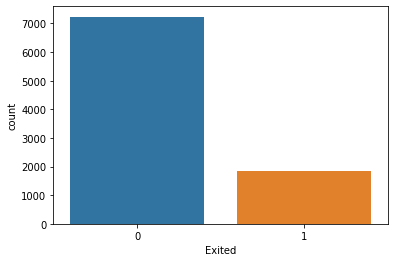

In [20]:
sns.countplot(x='Exited', data=churn_data_encode);

In [21]:
churn_data_encode.Exited.value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

Видно, что количество записей с классом 0 значительно превышает количество записей с классом 1. 

In [22]:
print('Соотношение классов в тренировочной выборке: {:.3}'.format(y_train.mean()))
print('Соотношение классов в валидационной выборке: {:.3}'.format(y_val.mean()))
print('Соотношение классов в тестовой выборке: {:.3}'.format(y_test.mean()))

Соотношение классов в тренировочной выборке: 0.203
Соотношение классов в валидационной выборке: 0.204
Соотношение классов в тестовой выборке: 0.206


Видно что баланс классов в выборках соблюден, и число ушедших клиентов примерно равно 20%

Попробуем обучить случайный лес не учитывая при этом дисбаланс классов.

In [23]:
model = RandomForestClassifier(random_state=42)

In [24]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
predicted_val = model.predict(X_val)

Посмотрим на значение accuracy и матрицу ошибок.

In [26]:
accuracy_score(y_val, predicted_val)

0.8591859185918592

In [27]:
confusion_matrix(y_val, predicted_val)

array([[1373,   74],
       [ 182,  189]])

Выходит достаточно неплохо. Однако если предсказывать всем записям 0 класс - точность будет незначительно ниже. Модель хорошо предсказывает записи 0 класса, а вот 1 класс часто тоже считает 0. Настолько, что FN даже больше чем TP! 

Проверим F1-score, a также precision и recall. 

In [28]:
f1_score(y_val, predicted_val)

0.5962145110410094

In [29]:
print(classification_report(y_val, predicted_val))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1447
           1       0.72      0.51      0.60       371

    accuracy                           0.86      1818
   macro avg       0.80      0.73      0.76      1818
weighted avg       0.85      0.86      0.85      1818



От единицы он достаточно далеко. Видимо дизбаланс классов плохо влияет на итоговую модель.

Визуализируем roc-кривую.

In [30]:
y_pred_proba = model.predict_proba(X_val)[::,1]

In [31]:
roc_auc_score(y_val, y_pred_proba)

0.860448329753724

In [32]:
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

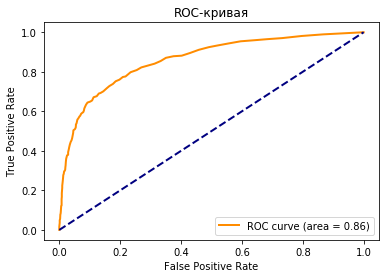

In [33]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right");

### Вывод

Полученная модель хорошо предсказывает значения для 0 класса, однако плохо справляется с определением 1 класса. Несмотря на хорошую accuracy модель в 53% случаев предсказывает объект 1 класса неправильно (Полнота для первого класса - 0.47). В настоящее время f1 score - 0.57, roc_auc_score - 0.82.

# 3. Борьба с дисбалансом

Попробуем несколько способов борьбы с дисбалансом классов. Сначала применим взвешивание классов, которое в случае случайного леса осуществляется с помошью аргумента class_weight модели.

In [34]:
model_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')

In [35]:
model_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [36]:
accuracy_score(y_val, model_balanced.predict(X_val))

0.8586358635863587

In [37]:
f1_score(y_val, model_balanced.predict(X_val))

0.5766062602965404

Качество модели снизилось, потому что почему бы и нет. 

Теперь попробуем использовать downsampling для уменьшения количества образцов доминирующего класса. Напишем функцию для этого.

In [38]:
def downsample(features, target, fraction):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.DataFrame(target[target == 0])
    target_ones = pd.DataFrame(target[target == 1])

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

Сократим количество образцов 0 класса в тренировочный выборке в 3 раза. Так количество образцов кажлого класса будет примерно равным.

In [39]:
X_train_downsampled, y_train_downsampled = downsample(X_train, y_train, 0.33)

Попробуем обучить модель с новыми данными.

In [40]:
model_downsample = RandomForestClassifier(random_state=42)

In [41]:
model_downsample.fit(X_train_downsampled, y_train_downsampled)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(random_state=42)

In [42]:
predicted_val_downsmpl = model_downsample.predict(X_val)

In [43]:
accuracy_score(y_val, predicted_val_downsmpl)

0.8162816281628162

In [44]:
confusion_matrix(y_val, predicted_val_downsmpl)

array([[1229,  218],
       [ 116,  255]])

Модель стала лучше определять класс 1, но значительно хуже класс 0. 

In [45]:
f1_score(y_val, predicted_val_downsmpl)

0.6042654028436019

F1-score вырос до 0.58

In [46]:
y_pred_proba_dwns = model_downsample.predict_proba(X_val)[::,1]

In [47]:
roc_auc_score(y_val, y_pred_proba_dwns)

0.8540450825855893

ROC-AUC-score так же вырос.

Используя upsampling теперь увеличим количество объектов первого класса в выборке. ~~Подло скопируем~~ Напишем для этого функцию.

In [48]:
def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

Скопируем тестовую часть 3 раза. Так данных обоих классов в выборке станет практически поровну. 

In [49]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 3)

Попробуем обучить модель с новыми данными. 

In [50]:
model_upsample = RandomForestClassifier(random_state=42)

In [51]:
model_upsample.fit(X_train_upsampled, y_train_upsampled)

RandomForestClassifier(random_state=42)

Проверим полученную модель. 

In [52]:
predicted_val_upsmpl = model_upsample.predict(X_val)

In [53]:
accuracy_score(y_val, predicted_val_upsmpl)

0.8525852585258525

In [54]:
confusion_matrix(y_val, predicted_val_upsmpl)

array([[1339,  108],
       [ 160,  211]])

Видно, что модель стала чуть хуже предсказывать 0 класс, по сравнению с моделью, обученной без upsampling'а, и accuracy в целом не изменилось. Однако модель теперь гораздо лучше предсказывает 1 класс.

In [55]:
f1_score(y_val, predicted_val_upsmpl)

0.6115942028985508

F1-score вырос до 0.6

In [56]:
y_pred_proba_ups = model_upsample.predict_proba(X_val)[::,1]

In [57]:
roc_auc_score(y_val, y_pred_proba_ups)

0.8608469609956094

In [58]:
fpr1, tpr1, _ = roc_curve(y_val, y_pred_proba_dwns)

In [59]:
fpr2, tpr2, _ = roc_curve(y_val, y_pred_proba_ups)

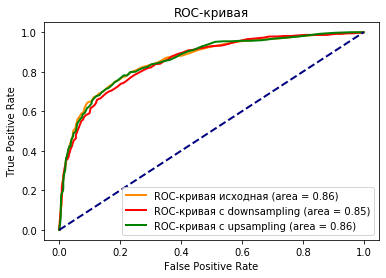

In [60]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC-кривая исходная (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba))
plt.plot(fpr1, tpr1, color='red',
         lw=2, label='ROC-кривая c downsampling (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba_dwns))
plt.plot(fpr2, tpr2, color='green',
         lw=2, label='ROC-кривая c upsampling (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba_ups))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right");

### Вывод

Видно, что при использовании upsampling качество модели улучшилось, сильнее, чем при использовании downsampling. Вырос f1-score и roc_auc_score, а вот accuracy осталась практически без изменений, так как теперь модель несколько хуже определяет 0 класс.

# 4. Тестирование модели

Обучим модель на совместной тренировочной и валидационной выборке, предварительно избавясь от дизбаланса классов в них с помощью upsampling'а

In [61]:
X_train_val_upsampled, y_train_val_upsampled = upsample(X_train_val, y_train_val, 4)

Обучим модель, подбирая гиперпараметры при помощи кросвалидации. 

In [62]:
param_dist = {'n_estimators': [500,700],
               'max_depth': list(range(10, 18, 2)),
               'min_samples_split': list(range(10, 18, 2)),
               'min_samples_leaf': list(range(1, 3))}

In [63]:
grid_model = GridSearchCV(RandomForestClassifier(n_estimators=700,random_state=42), 
                        param_dist, 
                        scoring='f1',
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1)

In [64]:
grid_model.fit(X_train_val_upsampled, y_train_val_upsampled)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 21.1min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=700,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 12, 14, 16],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [10, 12, 14, 16],
                         'n_estimators': [500, 700]},
             scoring='f1', verbose=1)

In [65]:
grid_model.best_params_

{'max_depth': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 700}

Сделаем предсказание по тестовой выборке. 

In [66]:
predicted_test = grid_model.predict(X_test)

In [67]:
accuracy_score(y_test, predicted_test)

0.8482682792743266

In [68]:
confusion_matrix(y_test, predicted_test)

array([[1316,  129],
       [ 147,  227]])

Проверим F1-score

In [69]:
f1_score(y_test, predicted_test)

0.6219178082191781

Значение метрики даже выше необходимого в 0.59. Ура!

Построим так же ROC-кривую

In [70]:
y_pred_proba_test = grid_model.predict_proba(X_test)[::,1]

In [71]:
roc_auc_score(y_test, y_pred_proba_test)

0.8486223932794257

In [72]:
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba_test)

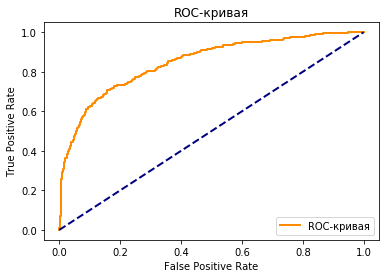

In [73]:
plt.plot(fpr3, tpr3, color='darkorange',
         lw=2, label='ROC-кривая' % roc_auc_score(y_test, y_pred_proba_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right");

# Вывод

Баланс классов в исходином датасете был наруешен, из-за чего подель плохо определяла минорный класс. С помощью метода upsampling'a удалось повысить предсказательную способность модели. Модель стала несколько хуже определять доминирующий класс, но общее качество повысилось. Итоговое значение F1-score для теста для настроенного случайного леса и увеличиной выборки 0.85, ROC-AUC-score - 0.76. Accuracy так же выше чем получена при использовании всегда предсказывающей 0 класс модели, что говорит о её адекватности.  